In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import matplotlib as mpl

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

from brevitas.export import export_onnx_qcdq

import torchmetrics

import cv2

import config_aimet
import dataset
import models_aimet_high
#import models_aimet_low
#import models_aimet_medium
import loss
import metrics
import train_epoch
import val_epoch
import utils

In [2]:
#torch.cuda.empty_cache()

# Define Matplotlib Style

In [3]:
mpl.style.use('seaborn-v0_8')

# Logger

In [4]:
log_path = config_aimet.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\tAdding best mean F1 save.\n' +
            '\t256 Normalization.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            '\tModels imported after AIMET processing.\n' +
            '\t\tPruning after SVD.\n' +
            '\t\tSVD after Pruning.\n' +
            '\tBrevitas with All Layers defined in the Model, but Dropout and Flatten.\n' +
            '\tBit width of Big Layers separated.\n' +
            '\tQuantIdentity with Uint8Act added and constant scale factor.\n' +
            '\tWeights with Per Channel Quant.\n' +
            '\tIntBias, Internal Scale with FixedPoint.\n' +
            f'\tFixed Point: {config_aimet.FIXED_POINT}.\n' +
            f'\tWeights bit width = {config_aimet.WEIGHTS_BIT_WIDTH}.\n' +
            f'\tBig Layers Weights bit width = {config_aimet.BIG_LAYERS_WEIGHTS_BIT_WIDTH}.\n' +
            f'\tActivations bit width = {config_aimet.ACTIVATIONS_BIT_WIDTH}.\n' +
            f'\tBias bit width = {config_aimet.BIAS_BIT_WIDTH}.\n' +
            f'\t{config_aimet.EPOCHS} epochs.\n')

# View Dataset

### Transform

In [5]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config_aimet.IMG_H, config_aimet.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [6]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset.DFireDataset(
    img_h=config_aimet.IMG_H, 
    img_w=config_aimet.IMG_W, 
    img_dir=config_aimet.val_imgs, 
    label_dir=config_aimet.val_labels, 
    num_classes=config_aimet.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

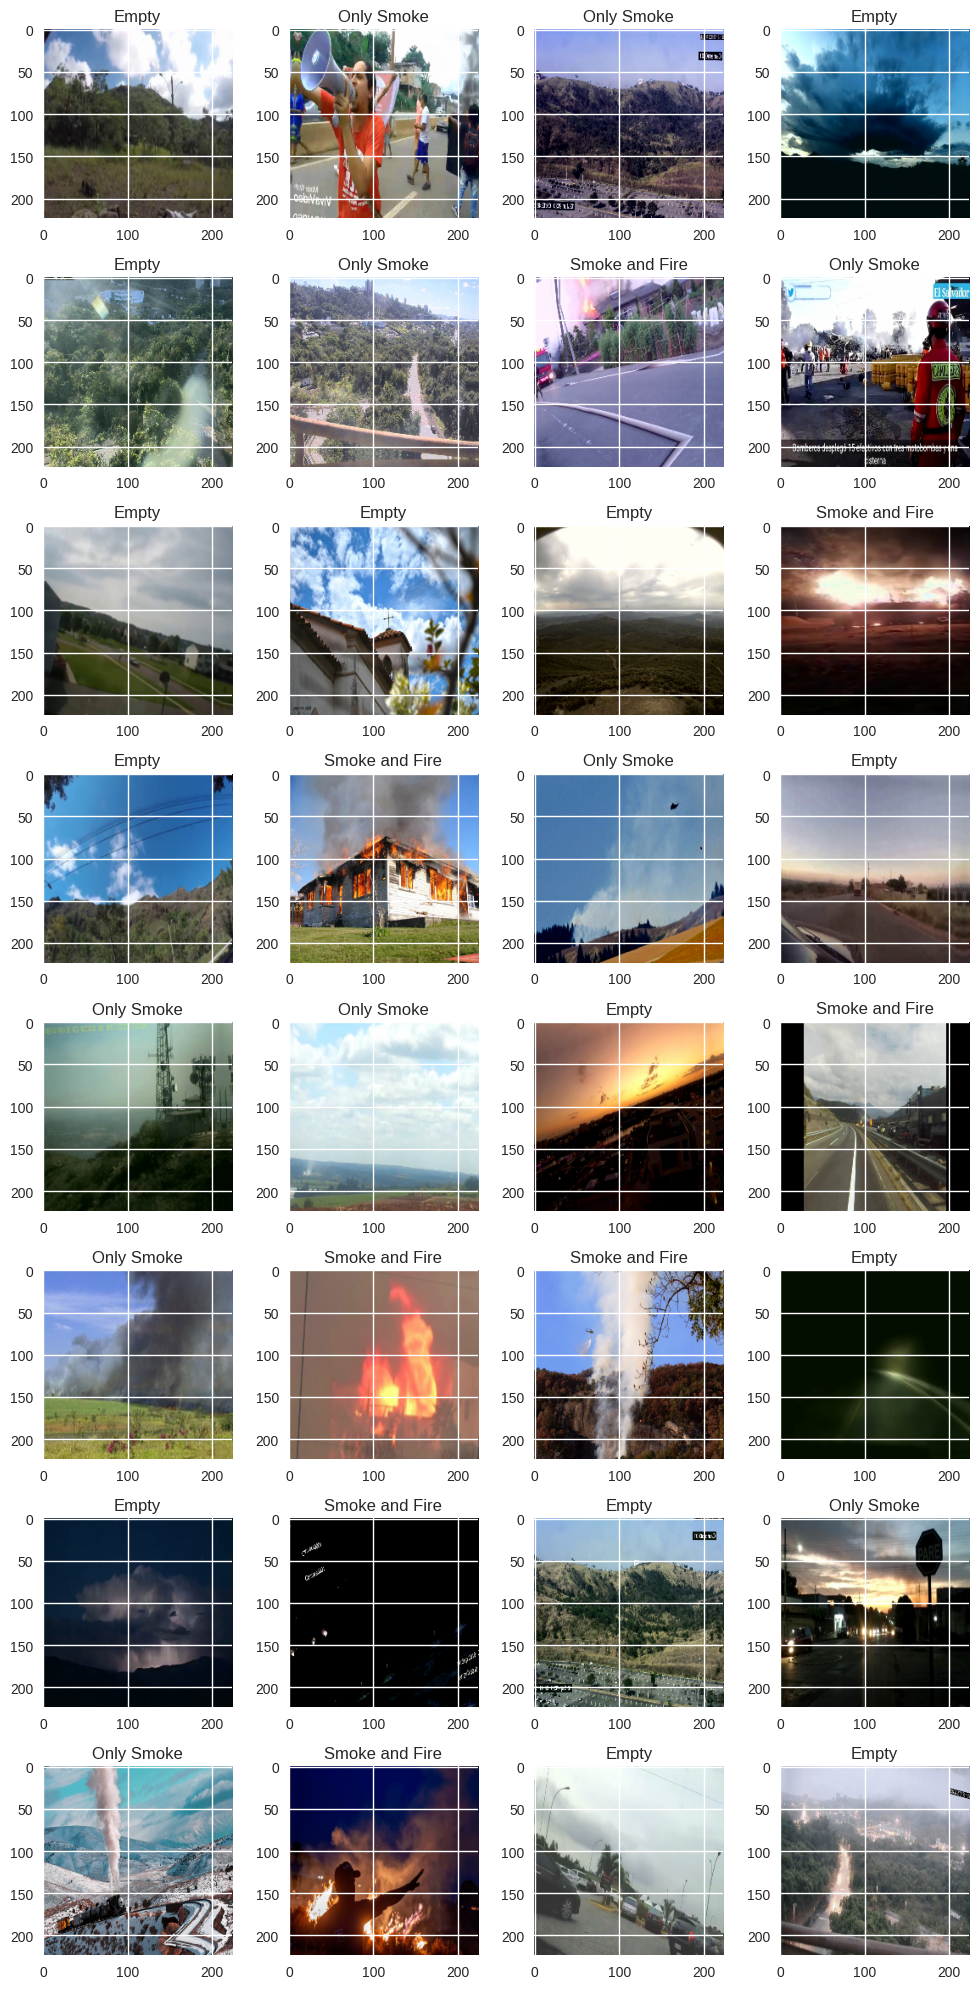

In [7]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

## Train

In [8]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config_aimet.IMG_H, config_aimet.IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = dataset.DFireDataset(
    img_h = config_aimet.IMG_H,
    img_w = config_aimet.IMG_W,
    img_dir = config_aimet.TRAIN_IMG_DIR,
    label_dir = config_aimet.TRAIN_LABEL_DIR,
    num_classes=config_aimet.N_CLASSES,
    ds_len = config_aimet.DS_LEN,
    transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')

# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=config_aimet.BATCH_SIZE,
                          num_workers=config_aimet.NUM_WORKERS,
                          pin_memory=config_aimet.PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)


TRAIN DFIRE dataset


Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221


## Validation

In [9]:
# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(config_aimet.IMG_H, config_aimet.IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = dataset.DFireDataset(
    img_h = config_aimet.IMG_H,
    img_w = config_aimet.IMG_W,
    img_dir = config_aimet.VAL_IMG_DIR,
    label_dir = config_aimet.VAL_LABEL_DIR,
    num_classes = config_aimet.N_CLASSES,
    ds_len = config_aimet.DS_LEN,
    transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')

# LOADERS
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config_aimet.BATCH_SIZE,
                        num_workers=config_aimet.NUM_WORKERS,
                        pin_memory=config_aimet.PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Models Setup

In [10]:
if config_aimet.MODEL == "BED":
    
    print("Using BED Classifier")
    logger.info("\nUsing BED Classifier")
    fp32_model = models_aimet_high.ORIGINAL_PRUNING_AFTER_SVD_CLASSIFIER(num_classes=config_aimet.N_CLASSES).to(config_aimet.DEVICE)  
    #fp32_model = models_aimet_soft.ORIGINAL_SOFT_PRUNING_AFTER_SVD_CLASSIFIER(num_classes=config_aimet.N_CLASSES).to(config_aimet.DEVICE)  
    #fp32_model = models_aimet_medium.ORIGINAL_MEDIUM_PRUNING_AFTER_SVD_CLASSIFIER(num_classes=config_aimet.N_CLASSES).to(config_aimet.DEVICE)  
    
    print("Using Fixed Point Quantizers without BN")
    logger.info("Using Fixed Point Quantizers without BN")
    quant_model = models_aimet_high.QUANT_PRUNING_AFTER_SVD_CLASSIFIER(
            weight_bw = config_aimet.WEIGHTS_BIT_WIDTH,
            big_layers_weight_bw = config_aimet.BIG_LAYERS_WEIGHTS_BIT_WIDTH,
            act_bw = config_aimet.ACTIVATIONS_BIT_WIDTH,
            bias_bw = config_aimet.BIAS_BIT_WIDTH,
            num_classes=config_aimet.N_CLASSES).to(config_aimet.DEVICE)
    # quant_model = models_aimet_soft.QUANT_SOFT_PRUNING_AFTER_SVD_CLASSIFIER(
    #         weight_bw = config_aimet.WEIGHTS_BIT_WIDTH,
    #         big_layers_weight_bw = config_aimet.BIG_LAYERS_WEIGHTS_BIT_WIDTH,
    #         act_bw = config_aimet.ACTIVATIONS_BIT_WIDTH,
    #         bias_bw = config_aimet.BIAS_BIT_WIDTH,
    #         num_classes=config_aimet.N_CLASSES).to(config_aimet.DEVICE)
    # quant_model = models_aimet_medium.QUANT_MEDIUM_PRUNING_AFTER_SVD_CLASSIFIER(
    #         weight_bw = config_aimet.WEIGHTS_BIT_WIDTH,
    #         big_layers_weight_bw = config_aimet.BIG_LAYERS_WEIGHTS_BIT_WIDTH,
    #         act_bw = config_aimet.ACTIVATIONS_BIT_WIDTH,
    #         bias_bw = config_aimet.BIAS_BIT_WIDTH,
    #         num_classes=config_aimet.N_CLASSES).to(config_aimet.DEVICE)

else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

optimizer = optim.Adam(quant_model.parameters(), 
                       lr=config_aimet.LEARNING_RATE, 
                       weight_decay=config_aimet.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config_aimet.FACTOR, 
                                                 patience=config_aimet.PATIENCE, 
                                                 threshold=config_aimet.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config_aimet.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in quant_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(quant_model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Using Fixed Point Quantizers without BN

Trainable parameters = 54782
Total parameters = 54782



### Check Model Shape

In [11]:
in_rand_np = np.random.rand(4, 3, config_aimet.IMG_H, config_aimet.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config_aimet.DEVICE)
out_test = quant_model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{quant_model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{quant_model}')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


Model shape is tensor([[-0.0591,  0.1059],
        [-0.0539,  0.1062],
        [-0.0535,  0.0962],
        [-0.0553,  0.0972]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
QUANT_PRUNING_AFTER_SVD_CLASSIFIER(
  (model): Sequential(
    (input0): QuantIdentity(
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (act_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (fused_activation_quant_proxy): FusedActivationQuantProxy(
          (activation_impl): Identity()
          (tensor_quant): RescalingIntQuant(
            (int_quant): IntQuant(
              (float_to_int_impl): RoundSte()
              (tensor_clamp_impl): TensorClamp()
              (delay_wrapper): DelayWrapper(
                (delay_impl): _NoDelay()
              )
            )
            (scaling_impl): ConstScaling(
              (restrict_clamp_scaling): _RestrictClampValue(
                (clam

# Load Pretrained or Initialize Weights

In [12]:
fp32_optimizer = optim.Adam(
    fp32_model.parameters(), 
    lr=config_aimet.LEARNING_RATE, 
    weight_decay=config_aimet.WEIGHT_DECAY)

fp32_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    fp32_optimizer, 
    mode='min',
    factor=config_aimet.FACTOR, 
    patience=config_aimet.PATIENCE, 
    threshold=config_aimet.THRES, 
    threshold_mode='abs',
    min_lr=config_aimet.MIN_LR)

if config_aimet.LOAD_MODEL == False:
    if config_aimet.MODEL == "BED":
        fp32_model.__initialize_weights__()
        print("Initializing Weights")
        logger.info("Initializing Weights")
else:
    epochs_trained = utils.load_checkpoint(config_aimet.LOAD_MODEL_FILE, fp32_model, fp32_optimizer, fp32_scheduler, config_aimet.DEVICE)
    logger.info(f"Loading Model. Trained during {epochs_trained} epochs")

Loading Model. Trained during 23 epochs


# FP32 Original Model Baseline Evaluation

In [13]:
def evaluate_model(model, iterations, use_cuda):
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(val_loader):
            if use_cuda == True:
                x, y = x.to('cuda'), y.to('cuda')
            else:
                model.to('cpu')
            out = model(x)
            if iterations is not None:
                if batch_idx == iterations:
                    break
            
            # F1 average Macro   
            yhat = torch.sigmoid(out.detach())
            metrics.precision_metric.update(yhat, y)
            metrics.recall_metric.update(yhat, y)
            metrics.accuracy_metric.update(yhat, y)
            metrics.f1_metric.update(yhat, y)
            metrics.f1_metric_mean.update(yhat, y)
    
        precision = metrics.precision_metric.compute()
        recall = metrics.recall_metric.compute()
        accuracy = metrics.accuracy_metric.compute()
        f1 = metrics.f1_metric.compute()
        f1_mean = metrics.f1_metric_mean.compute()
        
        metrics.precision_metric.reset()
        metrics.recall_metric.reset()
        metrics.accuracy_metric.reset()
        metrics.f1_metric.reset()
        metrics.f1_metric_mean.reset()

        print(f'Precision -> smoke: {precision[0]:.4f} - fire: {precision[1]:.4f}')
        print(f'Recall: -> smoke: {recall[0]:.4f} - fire: {recall[1]:.4f}')
        print(f'Accuracy: -> smoke: {accuracy[0]:.4f} - fire: {accuracy[1]:.4f}')
        print(f'F1: -> smoke: {f1[0]:.4f} - fire: {f1[1]:.4f}')
        print(f'F1 mean: {f1_mean:.4f}')
    
    return f1_mean.item()

In [14]:
baseline_F1_mean = evaluate_model(fp32_model, None, True)

Precision -> smoke: 0.9095 - fire: 0.9322
Recall: -> smoke: 0.9016 - fire: 0.9162
Accuracy: -> smoke: 0.9095 - fire: 0.9611
F1: -> smoke: 0.9056 - fire: 0.9241
F1 mean: 0.9148


# Torchinfo: model summary

### Quant Model

In [15]:
print(summary(quant_model, input_size=(config_aimet.BATCH_SIZE, 3, config_aimet.IMG_H, config_aimet.IMG_W)))
logger.info("Quant Model Summary")
logger.info(summary(quant_model, input_size=(config_aimet.BATCH_SIZE, 3, config_aimet.IMG_H, config_aimet.IMG_W)))

Layer (type:depth-idx)                                                           Output Shape              Param #
QUANT_PRUNING_AFTER_SVD_CLASSIFIER                                               [64, 2]                   --
├─Sequential: 1-1                                                                [64, 2]                   --
│    └─QuantIdentity: 2-1                                                        [64, 3, 224, 224]         --
│    │    └─ActQuantProxyFromInjector: 3-1                                       [64, 3, 224, 224]         --
│    │    └─ActQuantProxyFromInjector: 3-2                                       [64, 3, 224, 224]         --
│    └─QuantReLU: 2-55                                                           --                        (recursive)
│    │    └─ActQuantProxyFromInjector: 3-89                                      --                        (recursive)
│    └─QuantIdentity: 2-3                                                        --              

### FP32 Model

In [16]:
print(summary(fp32_model, input_size=(1, 3, config_aimet.IMG_H, config_aimet.IMG_W)))
# print(summary(fp32_model, input_size=(config_aimet.BATCH_SIZE, 3, config_aimet.IMG_H, config_aimet.IMG_W)))
logger.info("Original FP32 Model Summary")
logger.info(summary(fp32_model, input_size=(config_aimet.BATCH_SIZE, 3, config_aimet.IMG_H, config_aimet.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
ORIGINAL_PRUNING_AFTER_SVD_CLASSIFIER    [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 22, 224, 224]         616
│    └─ReLU: 2-2                         [1, 22, 224, 224]         --
│    └─Dropout2d: 2-3                    [1, 22, 224, 224]         --
│    └─MaxPool2d: 2-4                    [1, 22, 112, 112]         --
│    └─Sequential: 2-5                   [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 6, 112, 112]          396
│    │    └─Conv2d: 3-2                  [1, 16, 112, 112]         304
│    └─ReLU: 2-6                         [1, 16, 112, 112]         --
│    └─Dropout2d: 2-7                    [1, 16, 112, 112]         --
│    └─MaxPool2d: 2-8                    [1, 16, 56, 56]           --
│    └─Conv2d: 2-9                       [1, 14, 56, 56]           238
│    └─ReLU

# Load Pretrained Weights from FP32 Model to Quant Model

In [17]:
# # Try to load fp32 weights to quant_model
from brevitas import config as brevitas_config

brevitas_config.IGNORE_MISSING_KEYS = True

### Load all Pretrained Weights

In [18]:
for fp32_name, fp32_mod in fp32_model.named_modules():
    for quant_name, quant_mod in  quant_model.named_modules():
        if fp32_name == quant_name:
            print(f'fp32 model name: {fp32_name} - quant model name: {quant_name}')
            if isinstance(fp32_mod, nn.Conv2d):
                if fp32_name == quant_name:
                    quant_mod.load_state_dict(fp32_mod.state_dict())
                    print(f'\t****** Loading weights of Conv2d layer fp32 {fp32_name} into quant {quant_name}')
            elif isinstance(fp32_mod, nn.Linear):
                if fp32_name == quant_name:
                    quant_mod.load_state_dict(fp32_mod.state_dict())
                    print(f'\t****** Loading weights of Linear layer fp32 {fp32_name} into quant {quant_name}')
            else:
                print(f'\t______ Ignore weights or params of layer fp32 {fp32_name} and quant {quant_name}')

fp32 model name:  - quant model name: 
	______ Ignore weights or params of layer fp32  and quant 
fp32 model name: model - quant model name: model
	______ Ignore weights or params of layer fp32 model and quant model
fp32 model name: model.conv1 - quant model name: model.conv1
	****** Loading weights of Conv2d layer fp32 model.conv1 into quant model.conv1
fp32 model name: model.relu1 - quant model name: model.relu1
	______ Ignore weights or params of layer fp32 model.relu1 and quant model.relu1
fp32 model name: model.dropout1 - quant model name: model.dropout1
	______ Ignore weights or params of layer fp32 model.dropout1 and quant model.dropout1
fp32 model name: model.maxpool2 - quant model name: model.maxpool2
	______ Ignore weights or params of layer fp32 model.maxpool2 and quant model.maxpool2
fp32 model name: model.conv2 - quant model name: model.conv2
	______ Ignore weights or params of layer fp32 model.conv2 and quant model.conv2
fp32 model name: model.conv2.0 - quant model name: 

# Loss Function

In [19]:
if config_aimet.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config_aimet.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config_aimet.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config_aimet.DEVICE, smoke_precision_weight=config_aimet.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [20]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config_aimet.DEVICE}')
print(f'Learning Rate: {config_aimet.LEARNING_RATE}')
print(f'Weight Decay: {config_aimet.WEIGHT_DECAY}')
print(f'Batch Size: {config_aimet.BATCH_SIZE}')
print(f'IMG DIMS: ({config_aimet.IMG_H}, {config_aimet.IMG_W})')

logger.info(f'\nDevice: {config_aimet.DEVICE}')
logger.info(f'Learning Rate: {config_aimet.LEARNING_RATE}')
logger.info(f'Weight Decay: {config_aimet.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config_aimet.FACTOR}')
logger.info(f'Scheduler patience: {config_aimet.PATIENCE}')
logger.info(f'Scheduler threshold: {config_aimet.THRES}')
logger.info(f'Scheduler min learning rate: {config_aimet.MIN_LR}')
logger.info(f'Batch Size: {config_aimet.BATCH_SIZE}')
logger.info(f'W: {config_aimet.IMG_W}\nH: {config_aimet.IMG_H}')
logger.info(f'Batch Size: {config_aimet.BATCH_SIZE}')
logger.info(f'W: {config_aimet.IMG_W}\nH: {config_aimet.IMG_H}')


Device: cuda
Learning Rate: 0.0001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [21]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config_aimet.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config_aimet.PLOTS_FOLDER, model_name=config_aimet.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config_aimet.PLOTS_FOLDER, model_name=config_aimet.MODEL, loss_or_metric='Metric')

# Main Function

In [22]:
def train_loop(model, start_epoch=0):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])
    best_mean_f1 = 0.

    #start_epoch = 0
    epochs_plot = []
        
    for epoch in range(start_epoch, config_aimet.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config_aimet.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config_aimet.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        current_lr = train_epoch.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config_aimet.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config_aimet.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config_aimet.WEIGHTS_FOLDER + config_aimet.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config_aimet.WEIGHTS_FOLDER + config_aimet.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config_aimet.WEIGHTS_FOLDER + config_aimet.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.9
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.9 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.9")
            logger.info("Saving model with precision > 0.9 and recall > 0.9")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config_aimet.WEIGHTS_FOLDER + config_aimet.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 

        # Save model if best mean F1 increases
        val_f1_mean = (val_metrics['F1'][0] + val_metrics['F1'][1]) / 2
        if (val_f1_mean > best_mean_f1) :
            best_mean_f1 = val_f1_mean
            print(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            logger.info(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            save_f1_name = 'best_mean_F1'
            save_name = config_aimet.WEIGHTS_FOLDER + config_aimet.MODEL + '_classifier__' + save_f1_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config_aimet.WEIGHTS_FOLDER + 'last_' + config_aimet.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [23]:
if __name__ == "__main__":
    
    print("Starting script\n")
    logger.info("Starting script\n")
    
    qnn_model = train_loop(model=quant_model)

Starting script


***Start Training: 13:03:59


=== EPOCH 0/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [02:45<00:00,  1.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.473      |25.144      |13.329      



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.447      |17.307      |9.140       
SMOKE -> Precision: 0.874 - Recall: 0.863 - Accuracy: 0.874 - F1: 0.869
FIRE -> Precision: 0.954 - Recall: 0.859 - Accuracy: 0.953 - F1: 0.904

Saving model with new best validation loss: 26.447
Saving model with best Mean F1: 0.8864

=== EPOCH 1/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:39<00:00,  6.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.434      |21.185      |10.249      



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.589      |16.821      |7.768       
SMOKE -> Precision: 0.929 - Recall: 0.798 - Accuracy: 0.873 - F1: 0.858
FIRE -> Precision: 0.922 - Recall: 0.916 - Accuracy: 0.958 - F1: 0.919

Saving model with new best validation loss: 24.589
Saving model with best Mean F1: 0.8888

=== EPOCH 2/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.185      |20.629      |9.556       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.428      |15.599      |7.829       
SMOKE -> Precision: 0.874 - Recall: 0.904 - Accuracy: 0.891 - F1: 0.888
FIRE -> Precision: 0.917 - Recall: 0.919 - Accuracy: 0.958 - F1: 0.918

Saving model with new best validation loss: 23.428
Saving model with best Mean F1: 0.9033

=== EPOCH 3/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.823      |20.142      |9.681       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.154      |15.597      |7.558       
SMOKE -> Precision: 0.889 - Recall: 0.885 - Accuracy: 0.891 - F1: 0.887
FIRE -> Precision: 0.931 - Recall: 0.920 - Accuracy: 0.962 - F1: 0.925

Saving model with new best validation loss: 23.154
Saving model with best Mean F1: 0.9060

=== EPOCH 4/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.088      |19.599      |9.489       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.157      |15.359      |7.799       
SMOKE -> Precision: 0.901 - Recall: 0.876 - Accuracy: 0.894 - F1: 0.889
FIRE -> Precision: 0.919 - Recall: 0.917 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 5/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.423      |19.943      |9.480       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.538      |15.246      |8.292       
SMOKE -> Precision: 0.884 - Recall: 0.913 - Accuracy: 0.900 - F1: 0.898
FIRE -> Precision: 0.897 - Recall: 0.931 - Accuracy: 0.954 - F1: 0.913

=== EPOCH 6/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.460      |19.894      |9.566       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.763      |15.000      |7.764       
SMOKE -> Precision: 0.892 - Recall: 0.897 - Accuracy: 0.898 - F1: 0.894
FIRE -> Precision: 0.958 - Recall: 0.878 - Accuracy: 0.958 - F1: 0.916

Saving model with new best validation loss: 22.763

=== EPOCH 7/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.729      |19.455      |9.274       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.945      |15.536      |7.408       
SMOKE -> Precision: 0.870 - Recall: 0.923 - Accuracy: 0.897 - F1: 0.896
FIRE -> Precision: 0.965 - Recall: 0.890 - Accuracy: 0.963 - F1: 0.926
Saving model with best Mean F1: 0.9109

=== EPOCH 8/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.152      |19.759      |9.393       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.861      |15.348      |7.513       
SMOKE -> Precision: 0.905 - Recall: 0.863 - Accuracy: 0.890 - F1: 0.883
FIRE -> Precision: 0.928 - Recall: 0.919 - Accuracy: 0.961 - F1: 0.923

=== EPOCH 9/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.896      |19.522      |9.374       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.941      |15.815      |8.126       
SMOKE -> Precision: 0.863 - Recall: 0.925 - Accuracy: 0.893 - F1: 0.893
FIRE -> Precision: 0.898 - Recall: 0.933 - Accuracy: 0.955 - F1: 0.915

=== EPOCH 10/99 ===
Learning Rate = 8e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.262      |19.236      |9.026       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.153      |15.700      |7.453       
SMOKE -> Precision: 0.902 - Recall: 0.850 - Accuracy: 0.884 - F1: 0.875
FIRE -> Precision: 0.944 - Recall: 0.905 - Accuracy: 0.962 - F1: 0.924

=== EPOCH 11/99 ===
Learning Rate = 8e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.381      |19.326      |9.055       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.043      |15.841      |7.203       
SMOKE -> Precision: 0.864 - Recall: 0.932 - Accuracy: 0.897 - F1: 0.897
FIRE -> Precision: 0.936 - Recall: 0.918 - Accuracy: 0.962 - F1: 0.927
Saving model with best Mean F1: 0.9119

=== EPOCH 12/99 ===
Learning Rate = 8e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.042      |19.139      |8.904       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.812      |16.315      |8.497       
SMOKE -> Precision: 0.852 - Recall: 0.939 - Accuracy: 0.892 - F1: 0.893
FIRE -> Precision: 0.876 - Recall: 0.943 - Accuracy: 0.951 - F1: 0.908

=== EPOCH 13/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.678      |18.785      |8.894       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.707      |15.121      |7.586       
SMOKE -> Precision: 0.893 - Recall: 0.886 - Accuracy: 0.894 - F1: 0.889
FIRE -> Precision: 0.966 - Recall: 0.886 - Accuracy: 0.962 - F1: 0.924

Saving model with new best validation loss: 22.707

=== EPOCH 14/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.841      |18.952      |8.890       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.261      |15.004      |7.257       
SMOKE -> Precision: 0.902 - Recall: 0.885 - Accuracy: 0.898 - F1: 0.893
FIRE -> Precision: 0.945 - Recall: 0.906 - Accuracy: 0.962 - F1: 0.925

Saving model with new best validation loss: 22.261

=== EPOCH 15/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.434      |18.669      |8.764       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.488      |14.694      |7.794       
SMOKE -> Precision: 0.893 - Recall: 0.901 - Accuracy: 0.900 - F1: 0.897
FIRE -> Precision: 0.892 - Recall: 0.941 - Accuracy: 0.955 - F1: 0.916

=== EPOCH 16/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.673      |18.661      |9.012       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.156      |14.936      |7.220       
SMOKE -> Precision: 0.902 - Recall: 0.886 - Accuracy: 0.899 - F1: 0.894
FIRE -> Precision: 0.924 - Recall: 0.932 - Accuracy: 0.963 - F1: 0.928

Saving model with new best validation loss: 22.156

=== EPOCH 17/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.686      |18.654      |9.032       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.830      |15.429      |7.401       
SMOKE -> Precision: 0.880 - Recall: 0.899 - Accuracy: 0.892 - F1: 0.889
FIRE -> Precision: 0.944 - Recall: 0.904 - Accuracy: 0.961 - F1: 0.924

=== EPOCH 18/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.711      |19.046      |8.664       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.574      |14.838      |7.736       
SMOKE -> Precision: 0.909 - Recall: 0.871 - Accuracy: 0.896 - F1: 0.890
FIRE -> Precision: 0.963 - Recall: 0.869 - Accuracy: 0.958 - F1: 0.914

=== EPOCH 19/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.789      |18.885      |8.904       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.502      |15.147      |7.355       
SMOKE -> Precision: 0.897 - Recall: 0.896 - Accuracy: 0.901 - F1: 0.897
FIRE -> Precision: 0.925 - Recall: 0.927 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 20/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.153      |18.603      |8.549       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.373      |14.368      |7.005       
SMOKE -> Precision: 0.896 - Recall: 0.899 - Accuracy: 0.901 - F1: 0.898
FIRE -> Precision: 0.944 - Recall: 0.907 - Accuracy: 0.962 - F1: 0.925

Saving model with new best validation loss: 21.373

=== EPOCH 21/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.391      |18.525      |8.865       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.928      |14.715      |7.213       
SMOKE -> Precision: 0.905 - Recall: 0.890 - Accuracy: 0.902 - F1: 0.898
FIRE -> Precision: 0.935 - Recall: 0.917 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 22/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.196      |18.391      |8.805       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.337      |15.769      |7.568       
SMOKE -> Precision: 0.918 - Recall: 0.844 - Accuracy: 0.889 - F1: 0.880
FIRE -> Precision: 0.962 - Recall: 0.887 - Accuracy: 0.962 - F1: 0.923

=== EPOCH 23/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.621      |18.850      |8.771       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.429      |15.097      |7.332       
SMOKE -> Precision: 0.906 - Recall: 0.882 - Accuracy: 0.899 - F1: 0.894
FIRE -> Precision: 0.952 - Recall: 0.897 - Accuracy: 0.962 - F1: 0.924

=== EPOCH 24/99 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.955      |18.404      |8.551       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.284      |14.703      |7.581       
SMOKE -> Precision: 0.885 - Recall: 0.917 - Accuracy: 0.903 - F1: 0.901
FIRE -> Precision: 0.897 - Recall: 0.940 - Accuracy: 0.956 - F1: 0.918

Saving model with new best smoke precision: 0.885

=== EPOCH 25/99 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.053      |18.201      |8.853       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.182      |15.047      |7.135       
SMOKE -> Precision: 0.891 - Recall: 0.903 - Accuracy: 0.900 - F1: 0.897
FIRE -> Precision: 0.946 - Recall: 0.890 - Accuracy: 0.958 - F1: 0.917

=== EPOCH 26/99 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.963      |18.280      |8.683       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.858      |15.434      |7.424       
SMOKE -> Precision: 0.912 - Recall: 0.848 - Accuracy: 0.888 - F1: 0.879
FIRE -> Precision: 0.925 - Recall: 0.912 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 27/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.546      |18.108      |8.438       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.278      |15.010      |7.268       
SMOKE -> Precision: 0.902 - Recall: 0.872 - Accuracy: 0.892 - F1: 0.886
FIRE -> Precision: 0.942 - Recall: 0.901 - Accuracy: 0.960 - F1: 0.921

=== EPOCH 28/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.740      |18.175      |8.564       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.652      |15.386      |7.266       
SMOKE -> Precision: 0.913 - Recall: 0.850 - Accuracy: 0.889 - F1: 0.880
FIRE -> Precision: 0.945 - Recall: 0.905 - Accuracy: 0.962 - F1: 0.925

=== EPOCH 29/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.928      |18.249      |8.679       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.565      |15.022      |7.543       
SMOKE -> Precision: 0.910 - Recall: 0.867 - Accuracy: 0.895 - F1: 0.888
FIRE -> Precision: 0.947 - Recall: 0.893 - Accuracy: 0.959 - F1: 0.919

=== EPOCH 30/99 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.210      |17.721      |8.489       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.555      |14.569      |6.986       
SMOKE -> Precision: 0.909 - Recall: 0.880 - Accuracy: 0.900 - F1: 0.895
FIRE -> Precision: 0.943 - Recall: 0.909 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 31/99 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.611      |18.057      |8.554       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.518      |14.243      |7.275       
SMOKE -> Precision: 0.907 - Recall: 0.895 - Accuracy: 0.905 - F1: 0.901
FIRE -> Precision: 0.942 - Recall: 0.905 - Accuracy: 0.961 - F1: 0.923

Saving model with new best smoke precision: 0.907
Saving model with best Mean F1: 0.9119

=== EPOCH 32/99 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.391      |18.065      |8.326       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.439      |14.341      |7.098       
SMOKE -> Precision: 0.903 - Recall: 0.892 - Accuracy: 0.902 - F1: 0.898
FIRE -> Precision: 0.938 - Recall: 0.919 - Accuracy: 0.963 - F1: 0.929
Saving model with best Mean F1: 0.9132

=== EPOCH 33/99 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.642      |18.071      |8.570       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.455      |14.225      |7.230       
SMOKE -> Precision: 0.897 - Recall: 0.899 - Accuracy: 0.902 - F1: 0.898
FIRE -> Precision: 0.947 - Recall: 0.897 - Accuracy: 0.960 - F1: 0.921

=== EPOCH 34/99 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.269      |17.912      |8.356       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.697      |15.259      |7.439       
SMOKE -> Precision: 0.914 - Recall: 0.860 - Accuracy: 0.894 - F1: 0.886
FIRE -> Precision: 0.944 - Recall: 0.898 - Accuracy: 0.960 - F1: 0.921

=== EPOCH 35/99 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.366      |17.836      |8.530       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.514      |14.527      |6.987       
SMOKE -> Precision: 0.900 - Recall: 0.894 - Accuracy: 0.901 - F1: 0.897
FIRE -> Precision: 0.937 - Recall: 0.914 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 36/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.023      |17.727      |8.296       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.933      |14.674      |7.260       
SMOKE -> Precision: 0.899 - Recall: 0.903 - Accuracy: 0.904 - F1: 0.901
FIRE -> Precision: 0.951 - Recall: 0.898 - Accuracy: 0.962 - F1: 0.924

=== EPOCH 37/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.056      |17.615      |8.442       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.287      |14.211      |7.077       
SMOKE -> Precision: 0.897 - Recall: 0.903 - Accuracy: 0.903 - F1: 0.900
FIRE -> Precision: 0.960 - Recall: 0.897 - Accuracy: 0.964 - F1: 0.927

Saving model with new best validation loss: 21.287
Saving model with best Mean F1: 0.9137

=== EPOCH 38/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.988      |17.613      |8.375       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.854      |14.700      |7.154       
SMOKE -> Precision: 0.913 - Recall: 0.875 - Accuracy: 0.900 - F1: 0.894
FIRE -> Precision: 0.958 - Recall: 0.895 - Accuracy: 0.963 - F1: 0.926

=== EPOCH 39/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.230      |17.593      |8.637       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.089      |14.140      |6.949       
SMOKE -> Precision: 0.908 - Recall: 0.889 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.944 - Recall: 0.916 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 21.089
Saving model with best Mean F1: 0.9143

=== EPOCH 40/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.256      |17.753      |8.503       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.562      |14.536      |7.026       
SMOKE -> Precision: 0.904 - Recall: 0.888 - Accuracy: 0.901 - F1: 0.896
FIRE -> Precision: 0.938 - Recall: 0.910 - Accuracy: 0.961 - F1: 0.924

=== EPOCH 41/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.530      |17.951      |8.578       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.014      |14.695      |7.319       
SMOKE -> Precision: 0.897 - Recall: 0.901 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.967 - Recall: 0.878 - Accuracy: 0.961 - F1: 0.921

=== EPOCH 42/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.605      |17.930      |8.675       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.870      |14.695      |7.175       
SMOKE -> Precision: 0.884 - Recall: 0.917 - Accuracy: 0.902 - F1: 0.900
FIRE -> Precision: 0.938 - Recall: 0.914 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 43/99 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.128      |17.878      |8.250       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.325      |14.369      |6.956       
SMOKE -> Precision: 0.900 - Recall: 0.898 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.948 - Recall: 0.907 - Accuracy: 0.963 - F1: 0.927

=== EPOCH 44/99 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.599      |18.037      |8.563       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.941      |14.694      |7.247       
SMOKE -> Precision: 0.909 - Recall: 0.874 - Accuracy: 0.897 - F1: 0.891
FIRE -> Precision: 0.944 - Recall: 0.903 - Accuracy: 0.961 - F1: 0.923

=== EPOCH 45/99 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.034      |17.609      |8.425       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.147      |14.342      |6.805       
SMOKE -> Precision: 0.897 - Recall: 0.899 - Accuracy: 0.902 - F1: 0.898
FIRE -> Precision: 0.947 - Recall: 0.912 - Accuracy: 0.964 - F1: 0.929

=== EPOCH 46/99 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.126      |17.741      |8.385       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.136      |15.089      |7.047       
SMOKE -> Precision: 0.914 - Recall: 0.860 - Accuracy: 0.894 - F1: 0.886
FIRE -> Precision: 0.936 - Recall: 0.914 - Accuracy: 0.962 - F1: 0.925

=== EPOCH 47/99 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.070      |17.603      |8.467       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.442      |14.497      |6.946       
SMOKE -> Precision: 0.893 - Recall: 0.911 - Accuracy: 0.905 - F1: 0.902
FIRE -> Precision: 0.944 - Recall: 0.916 - Accuracy: 0.964 - F1: 0.930
Saving model with best Mean F1: 0.9161

=== EPOCH 48/99 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.948      |17.598      |8.349       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.717      |14.533      |7.184       
SMOKE -> Precision: 0.913 - Recall: 0.870 - Accuracy: 0.898 - F1: 0.891
FIRE -> Precision: 0.959 - Recall: 0.890 - Accuracy: 0.962 - F1: 0.923

=== EPOCH 49/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.380      |17.128      |8.253       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.414      |14.287      |7.127       
SMOKE -> Precision: 0.899 - Recall: 0.902 - Accuracy: 0.904 - F1: 0.900
FIRE -> Precision: 0.944 - Recall: 0.905 - Accuracy: 0.962 - F1: 0.924

=== EPOCH 50/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.808      |17.307      |8.501       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.936      |14.030      |6.906       
SMOKE -> Precision: 0.898 - Recall: 0.907 - Accuracy: 0.906 - F1: 0.903
FIRE -> Precision: 0.955 - Recall: 0.909 - Accuracy: 0.965 - F1: 0.932

Saving model with new best validation loss: 20.936
Saving model with best Mean F1: 0.9171

=== EPOCH 51/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.101      |17.596      |8.504       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.334      |14.191      |7.142       
SMOKE -> Precision: 0.897 - Recall: 0.906 - Accuracy: 0.905 - F1: 0.901
FIRE -> Precision: 0.959 - Recall: 0.899 - Accuracy: 0.964 - F1: 0.928

=== EPOCH 52/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.193      |17.725      |8.468       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.157      |14.162      |6.994       
SMOKE -> Precision: 0.896 - Recall: 0.908 - Accuracy: 0.905 - F1: 0.902
FIRE -> Precision: 0.937 - Recall: 0.917 - Accuracy: 0.963 - F1: 0.927

=== EPOCH 53/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.882      |17.392      |8.490       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.313      |14.361      |6.952       
SMOKE -> Precision: 0.914 - Recall: 0.884 - Accuracy: 0.904 - F1: 0.899
FIRE -> Precision: 0.953 - Recall: 0.903 - Accuracy: 0.963 - F1: 0.927

=== EPOCH 54/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.558      |17.374      |8.184       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.593      |14.436      |7.157       
SMOKE -> Precision: 0.901 - Recall: 0.895 - Accuracy: 0.902 - F1: 0.898
FIRE -> Precision: 0.936 - Recall: 0.914 - Accuracy: 0.962 - F1: 0.925

=== EPOCH 55/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.744      |17.398      |8.346       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 17.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.165      |14.196      |6.969       
SMOKE -> Precision: 0.908 - Recall: 0.895 - Accuracy: 0.906 - F1: 0.901
FIRE -> Precision: 0.963 - Recall: 0.899 - Accuracy: 0.965 - F1: 0.930

Saving model with new best smoke precision: 0.908

=== EPOCH 56/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.147      |17.611      |8.536       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.292      |14.221      |7.071       
SMOKE -> Precision: 0.909 - Recall: 0.887 - Accuracy: 0.903 - F1: 0.898
FIRE -> Precision: 0.945 - Recall: 0.903 - Accuracy: 0.961 - F1: 0.924

=== EPOCH 57/99 ===
Learning Rate = 5.4975581388800055e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.721      |17.372      |8.349       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.638      |14.642      |6.996       
SMOKE -> Precision: 0.884 - Recall: 0.915 - Accuracy: 0.902 - F1: 0.899
FIRE -> Precision: 0.941 - Recall: 0.908 - Accuracy: 0.962 - F1: 0.924

=== EPOCH 58/99 ===
Learning Rate = 5.4975581388800055e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.635      |17.361      |8.273       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.271      |14.359      |6.912       
SMOKE -> Precision: 0.891 - Recall: 0.908 - Accuracy: 0.902 - F1: 0.899
FIRE -> Precision: 0.934 - Recall: 0.919 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 59/99 ===
Learning Rate = 5.4975581388800055e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.145      |17.566      |8.579       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.444      |14.457      |6.987       
SMOKE -> Precision: 0.905 - Recall: 0.884 - Accuracy: 0.899 - F1: 0.894
FIRE -> Precision: 0.940 - Recall: 0.917 - Accuracy: 0.963 - F1: 0.928

=== EPOCH 60/99 ===
Learning Rate = 4.3980465111040045e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.910      |17.472      |8.437       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.325      |14.303      |7.022       
SMOKE -> Precision: 0.898 - Recall: 0.906 - Accuracy: 0.905 - F1: 0.902
FIRE -> Precision: 0.948 - Recall: 0.913 - Accuracy: 0.964 - F1: 0.930

=== EPOCH 61/99 ===
Learning Rate = 4.3980465111040045e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.766      |17.348      |8.418       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.543      |14.304      |7.239       
SMOKE -> Precision: 0.904 - Recall: 0.893 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.921 - Recall: 0.924 - Accuracy: 0.960 - F1: 0.923

=== EPOCH 62/99 ===
Learning Rate = 4.3980465111040045e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 10.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.045      |17.540      |8.505       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.683      |14.535      |7.148       
SMOKE -> Precision: 0.882 - Recall: 0.922 - Accuracy: 0.903 - F1: 0.902
FIRE -> Precision: 0.923 - Recall: 0.929 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 63/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.995      |17.568      |8.427       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.204      |14.184      |7.019       
SMOKE -> Precision: 0.905 - Recall: 0.892 - Accuracy: 0.903 - F1: 0.898
FIRE -> Precision: 0.930 - Recall: 0.923 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 64/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.095      |17.662      |8.432       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.297      |14.163      |7.135       
SMOKE -> Precision: 0.900 - Recall: 0.895 - Accuracy: 0.902 - F1: 0.898
FIRE -> Precision: 0.937 - Recall: 0.919 - Accuracy: 0.963 - F1: 0.928

=== EPOCH 65/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.591      |17.285      |8.307       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.303      |14.340      |6.963       
SMOKE -> Precision: 0.897 - Recall: 0.901 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.952 - Recall: 0.906 - Accuracy: 0.964 - F1: 0.928

=== EPOCH 66/99 ===
Learning Rate = 2.8147497671065632e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.660      |17.262      |8.399       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.457      |14.485      |6.972       
SMOKE -> Precision: 0.919 - Recall: 0.871 - Accuracy: 0.901 - F1: 0.894
FIRE -> Precision: 0.955 - Recall: 0.905 - Accuracy: 0.964 - F1: 0.929

=== EPOCH 67/99 ===
Learning Rate = 2.8147497671065632e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.627      |17.273      |8.354       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.020      |14.084      |6.936       
SMOKE -> Precision: 0.896 - Recall: 0.909 - Accuracy: 0.905 - F1: 0.902
FIRE -> Precision: 0.941 - Recall: 0.915 - Accuracy: 0.963 - F1: 0.928

=== EPOCH 68/99 ===
Learning Rate = 2.8147497671065632e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.527      |17.191      |8.336       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.068      |14.033      |7.035       
SMOKE -> Precision: 0.907 - Recall: 0.887 - Accuracy: 0.902 - F1: 0.897
FIRE -> Precision: 0.943 - Recall: 0.911 - Accuracy: 0.963 - F1: 0.927

=== EPOCH 69/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.006      |17.508      |8.497       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.518      |14.308      |7.210       
SMOKE -> Precision: 0.906 - Recall: 0.892 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.944 - Recall: 0.904 - Accuracy: 0.961 - F1: 0.924

=== EPOCH 70/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.309      |17.150      |8.158       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 16.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.597      |14.397      |7.200       
SMOKE -> Precision: 0.897 - Recall: 0.909 - Accuracy: 0.906 - F1: 0.903
FIRE -> Precision: 0.941 - Recall: 0.914 - Accuracy: 0.963 - F1: 0.927

=== EPOCH 71/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.410      |17.355      |8.055       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.756      |14.573      |7.184       
SMOKE -> Precision: 0.895 - Recall: 0.900 - Accuracy: 0.901 - F1: 0.897
FIRE -> Precision: 0.945 - Recall: 0.905 - Accuracy: 0.962 - F1: 0.925

=== EPOCH 72/99 ===
Learning Rate = 1.8014398509482006e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.295      |17.167      |8.128       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.267      |14.207      |7.059       
SMOKE -> Precision: 0.914 - Recall: 0.876 - Accuracy: 0.901 - F1: 0.895
FIRE -> Precision: 0.946 - Recall: 0.905 - Accuracy: 0.962 - F1: 0.925

=== EPOCH 73/99 ===
Learning Rate = 1.8014398509482006e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.594      |17.363      |8.231       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.438      |14.363      |7.075       
SMOKE -> Precision: 0.892 - Recall: 0.905 - Accuracy: 0.902 - F1: 0.899
FIRE -> Precision: 0.941 - Recall: 0.911 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 74/99 ===
Learning Rate = 1.8014398509482006e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.558      |17.236      |8.322       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.992      |14.927      |7.065       
SMOKE -> Precision: 0.874 - Recall: 0.933 - Accuracy: 0.903 - F1: 0.902
FIRE -> Precision: 0.937 - Recall: 0.918 - Accuracy: 0.963 - F1: 0.928

=== EPOCH 75/99 ===
Learning Rate = 1.4411518807585606e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.648      |17.425      |8.223       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.358      |14.415      |6.942       
SMOKE -> Precision: 0.905 - Recall: 0.885 - Accuracy: 0.900 - F1: 0.895
FIRE -> Precision: 0.939 - Recall: 0.916 - Accuracy: 0.963 - F1: 0.927

=== EPOCH 76/99 ===
Learning Rate = 1.4411518807585606e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.106      |16.932      |8.174       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.232      |14.197      |7.035       
SMOKE -> Precision: 0.907 - Recall: 0.895 - Accuracy: 0.905 - F1: 0.901
FIRE -> Precision: 0.939 - Recall: 0.911 - Accuracy: 0.962 - F1: 0.925

=== EPOCH 77/99 ===
Learning Rate = 1.4411518807585606e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.707      |17.368      |8.339       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.256      |14.277      |6.980       
SMOKE -> Precision: 0.897 - Recall: 0.906 - Accuracy: 0.905 - F1: 0.902
FIRE -> Precision: 0.920 - Recall: 0.931 - Accuracy: 0.961 - F1: 0.925

=== EPOCH 78/99 ===
Learning Rate = 1.1529215046068486e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.680      |17.285      |8.395       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.366      |14.223      |7.143       
SMOKE -> Precision: 0.894 - Recall: 0.904 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.947 - Recall: 0.906 - Accuracy: 0.963 - F1: 0.926

=== EPOCH 79/99 ===
Learning Rate = 1.1529215046068486e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.509      |17.199      |8.310       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.829      |13.899      |6.930       
SMOKE -> Precision: 0.896 - Recall: 0.915 - Accuracy: 0.908 - F1: 0.905
FIRE -> Precision: 0.953 - Recall: 0.905 - Accuracy: 0.964 - F1: 0.928

Saving model with new best validation loss: 20.829

=== EPOCH 80/99 ===
Learning Rate = 1.1529215046068486e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.795      |17.329      |8.466       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.008      |14.125      |6.883       
SMOKE -> Precision: 0.901 - Recall: 0.905 - Accuracy: 0.906 - F1: 0.903
FIRE -> Precision: 0.942 - Recall: 0.917 - Accuracy: 0.964 - F1: 0.929

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 81/99 ===
Learning Rate = 1.1529215046068486e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.751      |17.234      |8.517       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.413      |14.339      |7.075       
SMOKE -> Precision: 0.904 - Recall: 0.893 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.950 - Recall: 0.906 - Accuracy: 0.963 - F1: 0.928

=== EPOCH 82/99 ===
Learning Rate = 1.1529215046068486e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.687      |17.411      |8.276       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.545      |14.459      |7.086       
SMOKE -> Precision: 0.902 - Recall: 0.887 - Accuracy: 0.899 - F1: 0.894
FIRE -> Precision: 0.938 - Recall: 0.910 - Accuracy: 0.961 - F1: 0.924

=== EPOCH 83/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.563      |17.407      |8.156       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.159      |14.059      |7.099       
SMOKE -> Precision: 0.899 - Recall: 0.896 - Accuracy: 0.902 - F1: 0.898
FIRE -> Precision: 0.924 - Recall: 0.930 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 84/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.396      |17.295      |8.102       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.514      |14.243      |7.271       
SMOKE -> Precision: 0.900 - Recall: 0.894 - Accuracy: 0.901 - F1: 0.897
FIRE -> Precision: 0.949 - Recall: 0.905 - Accuracy: 0.963 - F1: 0.927

=== EPOCH 85/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.845      |17.322      |8.523       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.882      |14.552      |7.330       
SMOKE -> Precision: 0.892 - Recall: 0.914 - Accuracy: 0.906 - F1: 0.903
FIRE -> Precision: 0.912 - Recall: 0.932 - Accuracy: 0.959 - F1: 0.922

=== EPOCH 86/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.001      |17.595      |8.407       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.455      |14.309      |7.145       
SMOKE -> Precision: 0.901 - Recall: 0.897 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.955 - Recall: 0.899 - Accuracy: 0.963 - F1: 0.926

=== EPOCH 87/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.352      |17.126      |8.226       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.732      |14.632      |7.100       
SMOKE -> Precision: 0.915 - Recall: 0.873 - Accuracy: 0.900 - F1: 0.893
FIRE -> Precision: 0.939 - Recall: 0.908 - Accuracy: 0.961 - F1: 0.923

=== EPOCH 88/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.687      |17.365      |8.322       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.367      |14.334      |7.032       
SMOKE -> Precision: 0.913 - Recall: 0.881 - Accuracy: 0.902 - F1: 0.897
FIRE -> Precision: 0.933 - Recall: 0.916 - Accuracy: 0.961 - F1: 0.925

=== EPOCH 89/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 10.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.302      |17.168      |8.134       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.290      |14.333      |6.957       
SMOKE -> Precision: 0.901 - Recall: 0.901 - Accuracy: 0.904 - F1: 0.901
FIRE -> Precision: 0.936 - Recall: 0.918 - Accuracy: 0.962 - F1: 0.927

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 90/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 10.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.770      |17.337      |8.433       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.973      |14.046      |6.927       
SMOKE -> Precision: 0.908 - Recall: 0.901 - Accuracy: 0.908 - F1: 0.904
FIRE -> Precision: 0.942 - Recall: 0.914 - Accuracy: 0.963 - F1: 0.928

Saving model with new best smoke precision: 0.908

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 91/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.697      |17.265      |8.432       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.445      |14.259      |7.186       
SMOKE -> Precision: 0.910 - Recall: 0.883 - Accuracy: 0.902 - F1: 0.896
FIRE -> Precision: 0.936 - Recall: 0.908 - Accuracy: 0.960 - F1: 0.922

=== EPOCH 92/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.667      |17.325      |8.342       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.337      |14.149      |7.188       
SMOKE -> Precision: 0.904 - Recall: 0.896 - Accuracy: 0.904 - F1: 0.900
FIRE -> Precision: 0.949 - Recall: 0.901 - Accuracy: 0.962 - F1: 0.924

=== EPOCH 93/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.488      |17.202      |8.286       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.006      |14.713      |7.292       
SMOKE -> Precision: 0.911 - Recall: 0.874 - Accuracy: 0.898 - F1: 0.892
FIRE -> Precision: 0.960 - Recall: 0.891 - Accuracy: 0.962 - F1: 0.924

=== EPOCH 94/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 10.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.562      |17.283      |8.279       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.141      |14.164      |6.977       
SMOKE -> Precision: 0.907 - Recall: 0.895 - Accuracy: 0.905 - F1: 0.901
FIRE -> Precision: 0.938 - Recall: 0.918 - Accuracy: 0.963 - F1: 0.928

=== EPOCH 95/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 10.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.560      |17.345      |8.215       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.358      |14.184      |7.173       
SMOKE -> Precision: 0.906 - Recall: 0.897 - Accuracy: 0.906 - F1: 0.902
FIRE -> Precision: 0.963 - Recall: 0.893 - Accuracy: 0.963 - F1: 0.927

=== EPOCH 96/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 10.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.713      |17.334      |8.379       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.197      |14.310      |6.886       
SMOKE -> Precision: 0.914 - Recall: 0.880 - Accuracy: 0.903 - F1: 0.897
FIRE -> Precision: 0.954 - Recall: 0.906 - Accuracy: 0.964 - F1: 0.929

=== EPOCH 97/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.521      |17.341      |8.180       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 15.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.087      |14.080      |7.007       
SMOKE -> Precision: 0.901 - Recall: 0.899 - Accuracy: 0.904 - F1: 0.900
FIRE -> Precision: 0.934 - Recall: 0.915 - Accuracy: 0.961 - F1: 0.924

=== EPOCH 98/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.187      |17.121      |8.066       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.511      |14.166      |7.346       
SMOKE -> Precision: 0.904 - Recall: 0.892 - Accuracy: 0.903 - F1: 0.898
FIRE -> Precision: 0.962 - Recall: 0.892 - Accuracy: 0.963 - F1: 0.926

=== EPOCH 99/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 269/269 [00:24<00:00, 10.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.483      |17.146      |8.338       



Validating: 100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:04<00:00, 16.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.018      |13.967      |7.051       
SMOKE -> Precision: 0.900 - Recall: 0.905 - Accuracy: 0.906 - F1: 0.902
FIRE -> Precision: 0.952 - Recall: 0.904 - Accuracy: 0.963 - F1: 0.927

***Script finished: 13:55:06

Time elapsed: 0:51:06.458985


# Export to ONNX

In [24]:
export_onnx_qcdq(
    qnn_model, 
    torch.randn(1, 3, config_aimet.IMG_H, config_aimet.IMG_W).to(config_aimet.DEVICE), 
    export_path=config_aimet.RUN_FOLDER+'pretrained_qcdq.onnx')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/brevitas/export/onnx/standard/manager.py:26: UserWarning: ONNX opset version set to 13, override with opset_version=
  warnings.warn(f"ONNX opset version set to {DEFAULT_OPSET}, override with {ka}=")


# Inference example

In [25]:
quant_model.eval()
ex_in = torch.randn((1, 3, 224, 224)).to(config_aimet.DEVICE)
ex_out = quant_model(ex_in)
ex_out

tensor([[-0.7656, -0.8750]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [26]:
# ex_in_2 = torch.randn((1, 3, 224, 224)).to(config_aimet.DEVICE)
# quant_identity = quant_model.model.input0(ex_in_2)

# Another ONNX Export option

In [27]:
from brevitas.export import export_qonnx
from brevitas.export import export_onnx_qop

In [28]:
# export_onnx_qop(
#     qnn_model, 
#     torch.randn(1, 3, config_aimet.IMG_H, config_aimet.IMG_W).to(config_aimet.DEVICE), 
#     export_path=config_aimet.RUN_FOLDER+'pretrained_qop.onnx')

In [29]:
# export_qonnx(
#     qnn_model, 
#     torch.randn(1, 3, config_aimet.IMG_H, config_aimet.IMG_W).to(config_aimet.DEVICE), 
#     export_path=config_aimet.RUN_FOLDER+'pretrained_qonnx.onnx')